# **Diagnóstico Automatizado de Linfomas Malignos en Biopsias H&E mediante Aprendizaje Automático**
## *Aftab Ahmed Choudhry*

In [67]:
from PIL import Image
import os
import glob
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, MobileNetV2, EfficientNetV2B0 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn import metrics
import seaborn as sns

## ***Conversión Única de Imágenes .tif a .png***

Esta celda se ejecuta **una sola vez** para convertir las imágenes originales descargadas desde Kaggle (en formato `.tif`) al formato `.png`, ya que `image_dataset_from_directory()` de TensorFlow **no soporta `.tif`**. Tras la conversión, las imágenes `.tif` se eliminan automáticamente.

In [2]:
base_path = './dataset'

for class_name in ['CLL', 'FL', 'MCL']:
    folder = os.path.join(base_path, class_name)
    tif_files = glob.glob(os.path.join(folder, '*.tif'))
    png_files = glob.glob(os.path.join(folder, '*.png'))

    if len(png_files) > 0:
        print(f"Conversión ya realizada para la clase {class_name}. Se omite.")
        continue

    for tif_path in tif_files:
        with Image.open(tif_path) as img:
            rgb_img = img.convert('RGB')
            new_path = tif_path.replace('.tif', '.png')
            rgb_img.save(new_path)

        os.remove(tif_path)
    
    print(f"Conversión completada para la clase {class_name}.")

Conversión ya realizada para la clase CLL. Se omite.
Conversión ya realizada para la clase FL. Se omite.
Conversión ya realizada para la clase MCL. Se omite.


## *Verificación de disponibilidad de GPU*

Esta celda comprueba si TensorFlow detecta una GPU en el entorno actual. Es útil para confirmar que la aceleración por hardware está activa y que se aprovechará la GPU durante el entrenamiento del modelo.

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


## Preproceso

In [4]:
def plot_accuracy_loss(history):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Carga de los datos

In [5]:
dataset_path = './dataset'
image_size = (299, 299)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size = image_size,
    shuffle = True,
    seed = 23,
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 374 files belonging to 3 classes.
Classes: ['CLL', 'FL', 'MCL']


### Visualización básica

In [ ]:
'''
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()} ({class_names[labels[i].numpy()]})")
        plt.axis("off")

### Partición del conjunto de datos

In [6]:
X = []
y = []

for images, labels in dataset:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 299, 299, 3), (75, 299, 299, 3), (299,), (75,))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=23, stratify=y_train)

print("Train:", X_train.shape, y_train.shape)
print("Validation:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (269, 299, 299, 3) (269,)
Validation:   (30, 299, 299, 3) (30,)
Test:  (75, 299, 299, 3) (75,)


In [ ]:
'''
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
df_train = pd.DataFrame(X_train_flattened)
df_train['target'] = y_train
df_train.head()

Reordenaremos las columnas de manera que la variable target sea la primera

In [ ]:
'''
cols = list(df_train.columns)
cols.remove('target')
cols.insert(0,'target')
df_train = df_train.reindex(columns=cols)
df_train.head()

In [ ]:
#df_train.iloc[:, :1000].describe().T

In [ ]:
#df_train['target'].value_counts()

## Entrenar la CNN

### InceptionV3

In [8]:
inceptionV3_base_model = InceptionV3(include_top = False)

#### Freeze and Feature Extraction

In [9]:
inceptionV3_base_model.trainable = False

In [10]:
inceptionV3_inputs = Input(shape = (299, 299, 3))

inceptionV3_x = tf.keras.applications.inception_v3.preprocess_input(inceptionV3_inputs)

inceptionV3_x = inceptionV3_base_model(inceptionV3_x)

inceptionV3_x = GlobalAveragePooling2D()(inceptionV3_x)

# inceptionV3_x = Dropout(0.2)(inceptionV3_x)

inceptionV3_outputs = Dense(3, activation = 'softmax')(inceptionV3_x)

inceptionV3_model = Model(inceptionV3_inputs, inceptionV3_outputs)

inceptionV3_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [11]:
len(inceptionV3_base_model.layers)

311

In [ ]:
'''
tf.keras.utils.plot_model(
    inceptionV3_model,
    to_file = 'InceptionV3.png',
    show_shapes = True,
    show_dtype = False,
    show_layer_names = False,
    show_layer_activations = True,
    expand_nested = True
)
'''

In [12]:
inceptionV3_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [13]:
EPOCHS = 15

In [14]:
inceptionV3_history = inceptionV3_model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val))

Epoch 1/15
9/9 [==============================] - 10s 450ms/step - loss: 1.2221 - accuracy: 0.3643 - val_loss: 1.1398 - val_accuracy: 0.3333
Epoch 2/15
9/9 [==============================] - 2s 182ms/step - loss: 0.9685 - accuracy: 0.5353 - val_loss: 1.0687 - val_accuracy: 0.4000
Epoch 3/15
9/9 [==============================] - 2s 183ms/step - loss: 0.9017 - accuracy: 0.5762 - val_loss: 1.0086 - val_accuracy: 0.5000
Epoch 4/15
9/9 [==============================] - 2s 182ms/step - loss: 0.7983 - accuracy: 0.6320 - val_loss: 0.9276 - val_accuracy: 0.5333
Epoch 5/15
9/9 [==============================] - 2s 184ms/step - loss: 0.7572 - accuracy: 0.6543 - val_loss: 0.8883 - val_accuracy: 0.6000
Epoch 6/15
9/9 [==============================] - 2s 184ms/step - loss: 0.7031 - accuracy: 0.6952 - val_loss: 0.8286 - val_accuracy: 0.6333
Epoch 7/15
9/9 [==============================] - 2s 183ms/step - loss: 0.6666 - accuracy: 0.7323 - val_loss: 0.8033 - val_accuracy: 0.7000
Epoch 8/15
9/9 [===

In [15]:
acc = inceptionV3_history.history['accuracy']
val_acc = inceptionV3_history.history['val_accuracy']

loss = inceptionV3_history.history['loss']
val_loss = inceptionV3_history.history['val_loss']

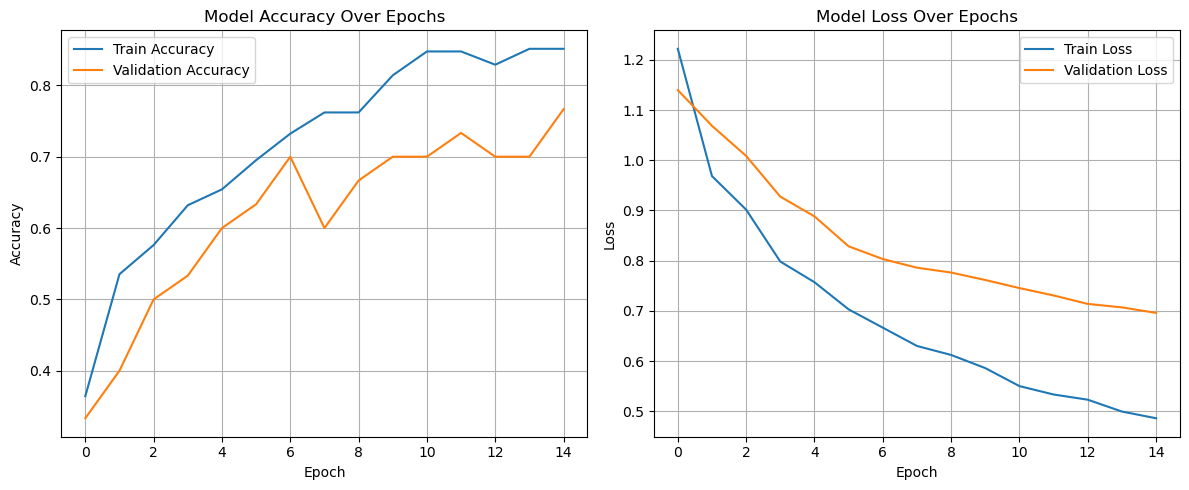

In [16]:
plot_accuracy_loss(inceptionV3_history)

#### Unfreeze and Fine-Tuning

In [22]:
inceptionV3_base_model.trainable = True
for layer in inceptionV3_base_model.layers[:-50]:
    layer.trainable = False

In [23]:
inceptionV3_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [24]:
inceptionV3_model.compile(loss = 'sparse_categorical_crossentropy',
                          optimizer = Adam(learning_rate = 0.0001),
                          metrics = ['accuracy'])

In [25]:
callbacks = [ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1),
             ReduceLROnPlateau(monitor = 'val_accuracy', patience = 4, factor = 0.1, verbose = 1, min_lr = 1e-6),
             EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 1)]

In [26]:
inceptionV3_history_fine = inceptionV3_model.fit(X_train, y_train, epochs = EPOCHS * 2, initial_epoch = EPOCHS, validation_data = (X_val, y_val))

Epoch 16/30
9/9 [==============================] - 7s 346ms/step - loss: 0.7687 - accuracy: 0.6840 - val_loss: 0.9635 - val_accuracy: 0.6667
Epoch 17/30
9/9 [==============================] - 2s 201ms/step - loss: 0.2383 - accuracy: 0.9480 - val_loss: 0.9878 - val_accuracy: 0.5333
Epoch 18/30
9/9 [==============================] - 2s 201ms/step - loss: 0.1084 - accuracy: 1.0000 - val_loss: 0.7787 - val_accuracy: 0.6333
Epoch 19/30
9/9 [==============================] - 2s 201ms/step - loss: 0.0526 - accuracy: 0.9926 - val_loss: 0.6944 - val_accuracy: 0.7000
Epoch 20/30
9/9 [==============================] - 2s 200ms/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 0.7291 - val_accuracy: 0.7333
Epoch 21/30
9/9 [==============================] - 2s 200ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.7576 - val_accuracy: 0.7333
Epoch 22/30
9/9 [==============================] - 2s 202ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.8202 - val_accuracy: 0.7333
Epoch 23/30
9

In [27]:
acc += inceptionV3_history_fine.history['accuracy']
val_acc += inceptionV3_history_fine.history['val_accuracy']

loss += inceptionV3_history_fine.history['loss']
val_loss += inceptionV3_history_fine.history['val_loss']

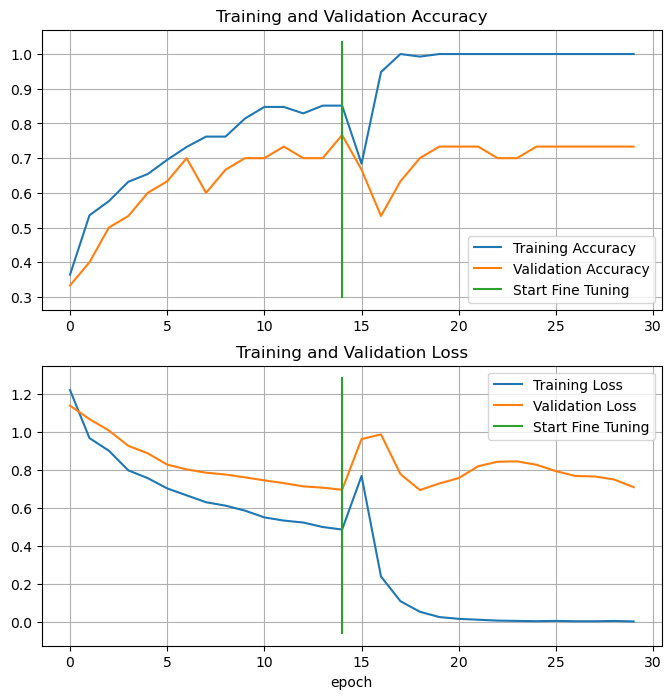

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

#### Evaluate Model

In [29]:
inceptionV3_model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 121ms/step - loss: 1.3053 - accuracy: 0.6400


[1.305309772491455, 0.6399999856948853]

In [30]:
predict_y = inceptionV3_model.predict(X_test)

3/3 [==============================] - 2s 297ms/step


In [31]:
predict_class = np.argmax(predict_y, axis=1)

In [32]:
confusion_matrix = metrics.confusion_matrix(y_test, predict_class)

<Axes: >

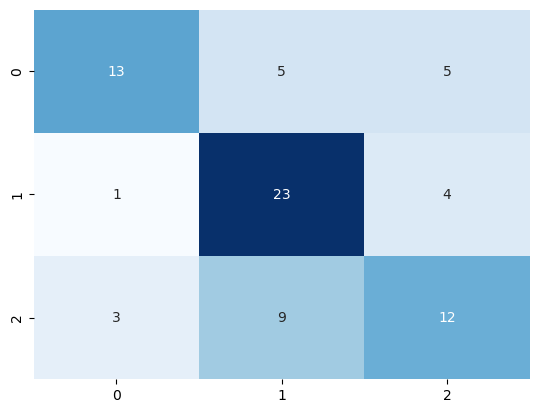

In [33]:
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

### MobileNetV2

In [34]:
dataset_path = './dataset'
image_size = (224, 224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size = image_size,
    shuffle = True,
    seed = 23,
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 374 files belonging to 3 classes.
Classes: ['CLL', 'FL', 'MCL']


In [35]:
X = []
y = []

for images, labels in dataset:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 224, 224, 3), (75, 224, 224, 3), (299,), (75,))

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=23, stratify=y_train)

print("Train:", X_train.shape, y_train.shape)
print("Validation:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (269, 224, 224, 3) (269,)
Validation:   (30, 224, 224, 3) (30,)
Test:  (75, 224, 224, 3) (75,)


In [37]:
mobileNetV2_base_model = MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
mobileNetV2_base_model.trainable = False

#### Freeze and Feature Extraction

In [38]:
mobileNetV2_inputs = Input(shape = (224, 224, 3))

mobileNetV2_x = tf.keras.applications.mobilenet_v2.preprocess_input(mobileNetV2_inputs)

mobileNetV2_x = mobileNetV2_base_model(mobileNetV2_x)

mobileNetV2_x = GlobalAveragePooling2D()(mobileNetV2_x)

# mobileNetV2_x = Dropout(0.2)(mobileNetV2_x)

mobileNetV2_outputs = Dense(3, activation = 'softmax')(mobileNetV2_x)

mobileNetV2_model = Model(mobileNetV2_inputs, mobileNetV2_outputs)

mobileNetV2_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [39]:
len(mobileNetV2_base_model.layers)

154

In [ ]:
'''
tf.keras.utils.plot_model(
    mobileNetV2_model,
    to_file = 'MobileNetV2.png',
    show_shapes = True,
    show_dtype = False,
    show_layer_names = False,
    show_layer_activations = True,
    expand_nested = True
)
'''

In [40]:
mobileNetV2_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [41]:
mobileNetV2_history = mobileNetV2_model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val))

Epoch 1/15
9/9 [==============================] - 3s 125ms/step - loss: 1.1911 - accuracy: 0.3941 - val_loss: 1.0841 - val_accuracy: 0.3333
Epoch 2/15
9/9 [==============================] - 0s 50ms/step - loss: 0.9249 - accuracy: 0.5576 - val_loss: 1.1011 - val_accuracy: 0.5000
Epoch 3/15
9/9 [==============================] - 0s 50ms/step - loss: 0.8212 - accuracy: 0.6134 - val_loss: 1.0147 - val_accuracy: 0.4667
Epoch 4/15
9/9 [==============================] - 0s 50ms/step - loss: 0.7344 - accuracy: 0.6952 - val_loss: 1.0295 - val_accuracy: 0.6000
Epoch 5/15
9/9 [==============================] - 0s 50ms/step - loss: 0.6722 - accuracy: 0.7472 - val_loss: 0.9567 - val_accuracy: 0.6000
Epoch 6/15
9/9 [==============================] - 0s 50ms/step - loss: 0.6392 - accuracy: 0.7361 - val_loss: 0.9707 - val_accuracy: 0.5000
Epoch 7/15
9/9 [==============================] - 0s 50ms/step - loss: 0.6057 - accuracy: 0.7695 - val_loss: 0.9302 - val_accuracy: 0.5333
Epoch 8/15
9/9 [==========

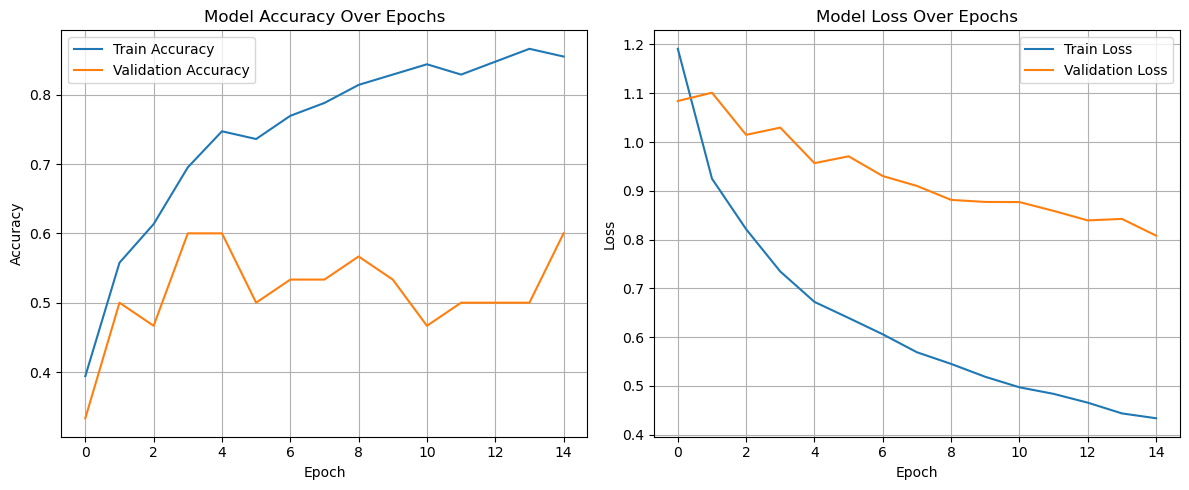

In [42]:
plot_accuracy_loss(mobileNetV2_history)

In [43]:
acc = mobileNetV2_history.history['accuracy']
val_acc = mobileNetV2_history.history['val_accuracy']

loss = mobileNetV2_history.history['loss']
val_loss = mobileNetV2_history.history['val_loss']

#### Unfreeze and Fine-Tuning

In [49]:
mobileNetV2_base_model.trainable = True

In [50]:
print("Number of layers in the base model: ", len(mobileNetV2_base_model.layers))

fine_tune_at = 100

for layer in mobileNetV2_base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [51]:
mobileNetV2_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [52]:
len(mobileNetV2_model.trainable_variables)

56

In [53]:
mobileNetV2_history = mobileNetV2_model.fit(X_train, y_train, epochs = EPOCHS + EPOCHS, initial_epoch = EPOCHS, validation_data = (X_val, y_val))

Epoch 16/30
9/9 [==============================] - 1s 55ms/step - loss: 0.4149 - accuracy: 0.8699 - val_loss: 0.8313 - val_accuracy: 0.5333
Epoch 17/30
9/9 [==============================] - 0s 50ms/step - loss: 0.4020 - accuracy: 0.8810 - val_loss: 0.8527 - val_accuracy: 0.5333
Epoch 18/30
9/9 [==============================] - 0s 50ms/step - loss: 0.3963 - accuracy: 0.8810 - val_loss: 0.7971 - val_accuracy: 0.5667
Epoch 19/30
9/9 [==============================] - 0s 50ms/step - loss: 0.3796 - accuracy: 0.8736 - val_loss: 0.8171 - val_accuracy: 0.5333
Epoch 20/30
9/9 [==============================] - 0s 50ms/step - loss: 0.3721 - accuracy: 0.8885 - val_loss: 0.8249 - val_accuracy: 0.5333
Epoch 21/30
9/9 [==============================] - 0s 51ms/step - loss: 0.3582 - accuracy: 0.8922 - val_loss: 0.7852 - val_accuracy: 0.6000
Epoch 22/30
9/9 [==============================] - 0s 50ms/step - loss: 0.3539 - accuracy: 0.8922 - val_loss: 0.8164 - val_accuracy: 0.5333
Epoch 23/30
9/9 [===

In [54]:
acc += mobileNetV2_history.history['accuracy']
val_acc += mobileNetV2_history.history['val_accuracy']

loss += mobileNetV2_history.history['loss']
val_loss += mobileNetV2_history.history['val_loss']

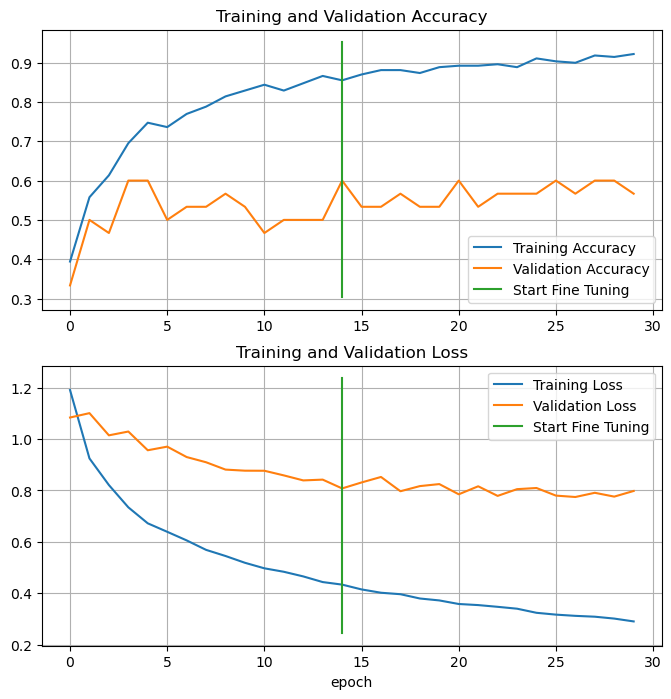

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

#### Evaluate Model

In [56]:
mobileNetV2_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 33ms/step - loss: 0.7597 - accuracy: 0.6800


[0.7596713304519653, 0.6800000071525574]

In [57]:
predict_y = mobileNetV2_model.predict(X_test)

3/3 [==============================] - 0s 41ms/step


In [58]:
predict_class = np.argmax(predict_y, axis=1)

In [59]:
confusion_matrix = metrics.confusion_matrix(y_test, predict_class)

<Axes: >

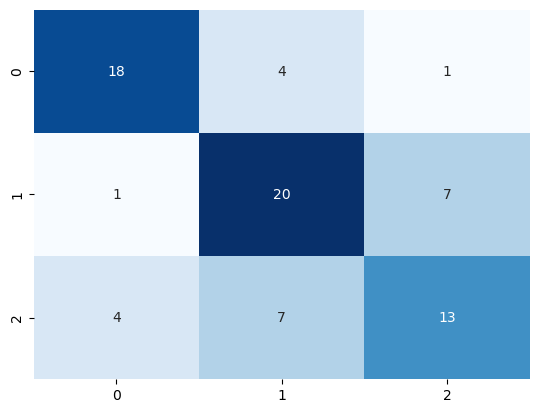

In [60]:
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

### EfficientNetV2B0

In [68]:
EfficientNetV2B0_base_model = EfficientNetV2B0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
EfficientNetV2B0.trainable = False

24274472/24274472 [==============================] - 2s 0us/step


#### Freeze and Feature Extraction

In [69]:
EfficientNetV2B0_inputs = Input(shape = (224, 224, 3))

EfficientNetV2B0_x = tf.keras.applications.efficientnet_v2.preprocess_input(EfficientNetV2B0_inputs)

EfficientNetV2B0_x = EfficientNetV2B0_base_model(EfficientNetV2B0_x)

EfficientNetV2B0_x = GlobalAveragePooling2D()(EfficientNetV2B0_x)

# EfficientNetV2B0_x = Dropout(0.2)(EfficientNetV2B0_x)

EfficientNetV2B0_outputs = Dense(3, activation = 'softmax')(EfficientNetV2B0_x)

EfficientNetV2B0_model = Model(EfficientNetV2B0_inputs, EfficientNetV2B0_outputs)

EfficientNetV2B0_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 5,862,547
Non-trainable params: 60,608
_________________________________________________________________


In [70]:
len(EfficientNetV2B0_base_model.layers)

270

In [71]:
EfficientNetV2B0_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [ ]:
EfficientNetV2B0_history = EfficientNetV2B0_model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val))